# 26. GAN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 26.1 Prepare MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

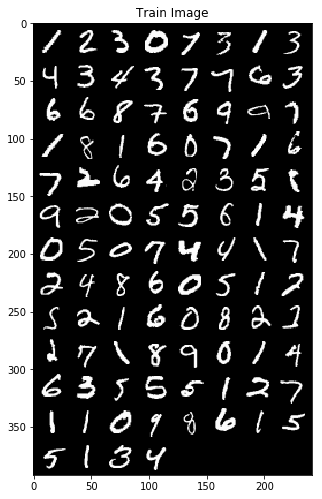

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 26.2 Define Model

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(28*28, 500),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(500, 250),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(250, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        out = self.discriminator(x)
        return out

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(100, 250),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(250, 500),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(500, 28*28),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.generator(x)
        out = out.view(-1, 1, 28, 28)
        return out

In [9]:
D = Discriminator().cuda()
G = Generator().cuda()

## 26.3 Train Model

In [10]:
def gan_loss(x, target_is_real):
    
    loss = nn.BCELoss()
    
    if target_is_real : 
        target_tensor = torch.ones(batch_size, 1)
    else :
        target_tensor = torch.zeros(batch_size, 1)
        
    return loss(x, Variable(target_tensor).cuda())

In [11]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = optim.Adam(D.parameters(), lr=0.0001)

In [12]:
num_epochs = 50

In [13]:
for epoch in range(num_epochs):
        
    total_batch = len(mnist_train) // batch_size
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images).cuda()
            
        prob_real = D(images)
        D_loss_real = gan_loss(prob_real, True)

        z = Variable(torch.randn((batch_size, 100))).cuda()
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        D_loss_fake = gan_loss(prob_fake, False)
        
        D_loss = D_loss_real + D_loss_fake
        
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        z = Variable(torch.randn((batch_size, 100))).cuda()
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        G_loss = gan_loss(prob_fake, True)
        
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, D_loss.data[0], G_loss.data[0]))

Epoch [1/50], lter [100/600], D_Loss: 0.9031, G_Loss: 1.4063
Epoch [1/50], lter [200/600], D_Loss: 0.5856, G_Loss: 1.9559
Epoch [1/50], lter [300/600], D_Loss: 0.8588, G_Loss: 1.9254
Epoch [1/50], lter [400/600], D_Loss: 1.3879, G_Loss: 0.9714
Epoch [1/50], lter [500/600], D_Loss: 1.0881, G_Loss: 1.0423
Epoch [1/50], lter [600/600], D_Loss: 1.2778, G_Loss: 1.1020
Epoch [2/50], lter [100/600], D_Loss: 1.3345, G_Loss: 0.8403
Epoch [2/50], lter [200/600], D_Loss: 1.1318, G_Loss: 0.9146
Epoch [2/50], lter [300/600], D_Loss: 1.2013, G_Loss: 0.8836
Epoch [2/50], lter [400/600], D_Loss: 1.2328, G_Loss: 0.7699
Epoch [2/50], lter [500/600], D_Loss: 1.1645, G_Loss: 0.7839
Epoch [2/50], lter [600/600], D_Loss: 0.8451, G_Loss: 1.1452
Epoch [3/50], lter [100/600], D_Loss: 0.5073, G_Loss: 1.6142
Epoch [3/50], lter [200/600], D_Loss: 0.6401, G_Loss: 2.0193
Epoch [3/50], lter [300/600], D_Loss: 0.4177, G_Loss: 3.0268
Epoch [3/50], lter [400/600], D_Loss: 0.6814, G_Loss: 1.8785
Epoch [3/50], lter [500/

Epoch [23/50], lter [300/600], D_Loss: 0.4707, G_Loss: 3.1078
Epoch [23/50], lter [400/600], D_Loss: 0.5672, G_Loss: 2.4400
Epoch [23/50], lter [500/600], D_Loss: 0.5364, G_Loss: 2.6873
Epoch [23/50], lter [600/600], D_Loss: 0.5928, G_Loss: 2.2218
Epoch [24/50], lter [100/600], D_Loss: 0.6537, G_Loss: 2.3912
Epoch [24/50], lter [200/600], D_Loss: 0.5826, G_Loss: 2.4282
Epoch [24/50], lter [300/600], D_Loss: 0.5457, G_Loss: 2.7706
Epoch [24/50], lter [400/600], D_Loss: 0.6900, G_Loss: 2.2665
Epoch [24/50], lter [500/600], D_Loss: 0.5869, G_Loss: 2.5526
Epoch [24/50], lter [600/600], D_Loss: 0.5522, G_Loss: 2.5520
Epoch [25/50], lter [100/600], D_Loss: 0.8163, G_Loss: 2.1861
Epoch [25/50], lter [200/600], D_Loss: 0.7494, G_Loss: 3.0138
Epoch [25/50], lter [300/600], D_Loss: 0.5642, G_Loss: 2.6556
Epoch [25/50], lter [400/600], D_Loss: 0.4632, G_Loss: 2.6812
Epoch [25/50], lter [500/600], D_Loss: 0.4964, G_Loss: 2.7596
Epoch [25/50], lter [600/600], D_Loss: 0.6839, G_Loss: 2.2327
Epoch [2

Epoch [45/50], lter [400/600], D_Loss: 0.4988, G_Loss: 2.6849
Epoch [45/50], lter [500/600], D_Loss: 0.5800, G_Loss: 2.2827
Epoch [45/50], lter [600/600], D_Loss: 0.5436, G_Loss: 2.6486
Epoch [46/50], lter [100/600], D_Loss: 0.6307, G_Loss: 2.9152
Epoch [46/50], lter [200/600], D_Loss: 0.5334, G_Loss: 2.6194
Epoch [46/50], lter [300/600], D_Loss: 0.6476, G_Loss: 2.6740
Epoch [46/50], lter [400/600], D_Loss: 0.5182, G_Loss: 2.2966
Epoch [46/50], lter [500/600], D_Loss: 0.5967, G_Loss: 2.6997
Epoch [46/50], lter [600/600], D_Loss: 0.5260, G_Loss: 2.7247
Epoch [47/50], lter [100/600], D_Loss: 0.5395, G_Loss: 2.7466
Epoch [47/50], lter [200/600], D_Loss: 0.6426, G_Loss: 2.3928
Epoch [47/50], lter [300/600], D_Loss: 0.5611, G_Loss: 2.1877
Epoch [47/50], lter [400/600], D_Loss: 0.6464, G_Loss: 2.6212
Epoch [47/50], lter [500/600], D_Loss: 0.5777, G_Loss: 2.2014
Epoch [47/50], lter [600/600], D_Loss: 0.5149, G_Loss: 2.9840
Epoch [48/50], lter [100/600], D_Loss: 0.6436, G_Loss: 2.9002
Epoch [4

## 26.4 Test Model

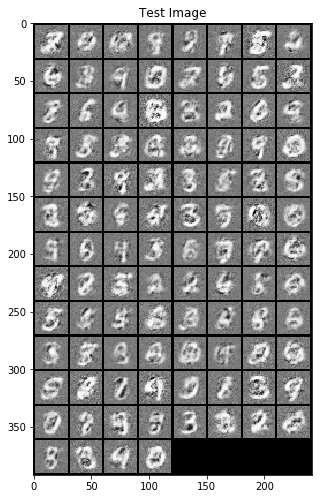

In [14]:
z = Variable(torch.randn((batch_size, 100))).cuda()
images = G(z)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Test Image")